# 2018 PyCon UK - Understanding sample bias in surveys about web services

**A fundamental problem of applying surveys about specialised topics or designed for a particular community is the underlying sample bias. We have designed a simple survey that asks respondents to score a set of web services in several aspects, including the quality of their software, their social and environmental impact, and their efforts in user experience (UX) and customer support. The survey has been applied separately to the developer team at Omni Digital, and to the attendees at *2018 PyCon UK*, which took place between 15/09 and 19/09.**

The following analysis cleans up the data and uses a two-sample Kolmogorov-Smirnov test to assess whether there are any differences between the distributions of scores throughout the entire dataset, for each attribute. This is a first step towards a method to effectively recognise and assess fundamental differences in concept between two communities, as well as to explore the possibility that specialised knowledge may have a direct influence in the wider scope of things.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# This cell reads the data from the API and cleans it up, removing unnecessary fields
fulldf = pd.read_json("http://pycon-data.omni-digital.co.uk/api/v1/survey_instances/?format=json")
df = fulldf[['completed_at', 'name', 'main', 'support', 'social', 'total']]
df = df.set_index('completed_at')

# All surveys corresponding to the Omni Digital team were taken on 14/09, while PyCon was held 15/09 to 19/09.
omni = df[:pd.datetime(2018,9,14,23,59)]
pycon = df[pd.datetime(2018,9,15):pd.datetime(2018,9,19,23,59)]

In [3]:
# We can obtain some basic information about the data set, including the list of services and the number of surveys
services = df.name.unique()
print(f"The following services have been used:")
for service in services:
    print(f"\t{service}")

total_count = fulldf.login.unique().size
omni_count = omni.loc[omni['name'] == 'Facebook'].name.count()
pycon_count = pycon.loc[pycon['name'] == 'Facebook'].name.count()

print(f"\nA total of {total_count} surveys have been submitted, of which:")
print(f"\t{omni_count} are from Omni Digital")
print(f"\t{pycon_count} are from 2018 PyCon UK")

The following services have been used:
	Google Analytics
	Amazon AWS
	Netflix
	Facebook
	Uber
	Spotify
	Squarespace
	Twitter
	Paypal
	Slack
	Reddit

A total of 30 surveys have been submitted, of which:
	8 are from Omni Digital
	22 are from 2018 PyCon UK


## Omni Digital

In [4]:
services = omni.groupby('name').mean().sort_values('total', ascending=False)
services

,main,support,social,total
name,,,,
Slack,8.375000,7.285714,7.500000,7.750000
Google Analytics,8.375000,6.125000,5.125000,7.291667
Netflix,9.000000,6.250000,5.750000,7.270833
Amazon AWS,8.375000,6.428571,4.571429,6.937500
Uber,7.750000,6.250000,5.250000,6.666667
Spotify,7.750000,5.750000,5.625000,6.583333
Paypal,7.125000,5.250000,6.000000,6.333333
Squarespace,5.714286,5.571429,5.333333,5.595238
Reddit,5.875000,3.375000,5.375000,5.145833


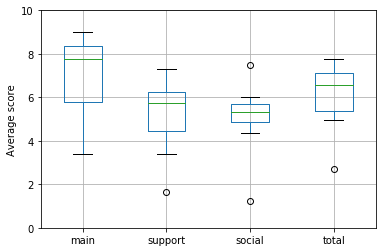

In [5]:
omni_boxplot = services.boxplot()
plt.ylim([0,10])
omni_boxplot_ylabel = plt.ylabel(f"Average score")

The box plot shows us that, generally, the `main` scores are higher and have larger dispersion than those in `support` and `social` aspects. However, this plot ignores the dispersion within the scoring of each service, and only compares across services.

On the other hand, if we calculate the probability mass function (pmf) and the cumulative mass function (cmf) across the entire dataset, the dispersion is better accounted for.

In [6]:
bins = pd.interval_range(start=-0.5, end=10.5)
omni_freq = omni.drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
omni_pmf = omni_freq/np.sum(omni_freq)
omni_cmf = np.cumsum(omni_pmf)

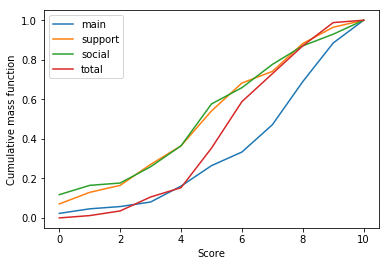

In [7]:
for key in omni_cmf.keys():
    plt.plot(bins.mid, omni_cmf[key])

legend = plt.legend()
xlabel = plt.xlabel(f"Score")
ylabel = plt.ylabel(f"Cumulative mass function")

We can see that there seems to be an alignment of the scores in `social` and `support` attributes, but the `main` scores seem to follow a different distribution. We can test whether this assumption is statistically significant using a two-sample Kolmogorov-Smirnov test. The statistic is calculated as the supremum of the absolute differences:

$$ D_{n,m} = \sup_x \left| F_{1,n}(x) - F_{2,m}(x) \right|,$$

and the null hypothesis, which can be phrased as "_the two samples are drawn from the same distribution_", is rejected if:

$$ D_{n,m} > c(\alpha)\sqrt{\frac{n + m}{nm}}.$$

In general, the value of the baseline $c(\alpha)$ is given by:

$$ c(\alpha) = \sqrt{-\frac{1}{2}\ln\left(\frac{\alpha}{2}\right)} $$

Alternatively, we can calculate the p-value of a given $D_{n,m}$ with known $n$ and $m$ by re-writing the formula:

$$ p\left(D_{n,m}, n, m\right) = 2e^{-2D_{n,m}^2\frac{nm}{n+m}} $$

In [8]:
def c(a):
    return np.sqrt(-0.5*np.log(a/2))

def pval(d, n, m):
    return 2*np.exp(-2*d**2*n*m/(n+m))

used = ['total']
for key1 in omni_cmf.drop(used, axis=1).keys():
    n = np.sum(omni_freq[key1])
    used.append(key1)
    for key2 in omni_cmf.drop(used, axis=1).keys():
        m = np.sum(omni_freq[key2])
        dnm = np.max(np.abs(omni_cmf[key1]-omni_cmf[key2]))
        ca = c(0.05)*np.sqrt((n+m)/(n*m))
        pv = pval(dnm, n, m)
        
        print(f"{key1}\t{key2}\t{dnm}\t{ca}\t{pv}\t{dnm>ca}")

main	support	0.34901960784313724	0.2071225423255308	5.648703459912517e-05	True
main	social	0.3254901960784313	0.2071225423255308	0.00022112253791288142	True
support	social	0.047058823529411764	0.20832326277472024	1.6568395240038107	False


These results show that there is a significant difference between the distributions obtained for the `main` scores and the `social` and `support` scores. It is a good indicator that, generally, the expectations of the respondents are different for each attribute.

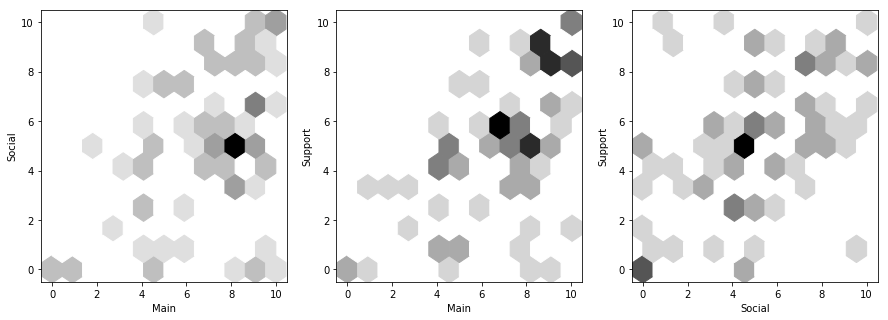

In [25]:
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.hexbin(omni.main, omni.social, gridsize=11, cmap='binary');
plt.xlabel(f"Main");
plt.ylabel(f"Social");

plt.subplot(1,3,2)
plt.hexbin(omni.main, omni.support, gridsize=11, cmap='binary');
plt.xlabel(f"Main");
plt.ylabel(f"Support");

plt.subplot(1,3,3)
plt.hexbin(omni.social, omni.support, gridsize=11, cmap='binary');
plt.xlabel(f"Social");
plt.ylabel(f"Support");

In [10]:
omni.drop(['name', 'total'], axis=1).corr()

,main,support,social
main,1.000000,0.605471,0.421846
support,0.605471,1.000000,0.485270
social,0.421846,0.485270,1.000000


## 2018 PyCon UK

In [11]:
services = pycon.groupby('name').mean().sort_values('total', ascending=False)
services

,main,support,social,total
name,,,,
Netflix,8.190476,6.850000,7.333333,7.500000
Slack,7.809524,6.500000,7.190476,7.309524
Spotify,7.666667,5.631579,6.818182,6.810606
Reddit,7.294118,6.235294,7.111111,6.740741
Amazon AWS,6.950000,6.842105,5.368421,6.166667
Twitter,6.894737,5.105263,6.105263,6.096491
Google Analytics,7.263158,5.777778,5.400000,6.025000
Paypal,7.200000,4.300000,5.500000,5.916667
Squarespace,5.615385,6.000000,5.230769,5.871795


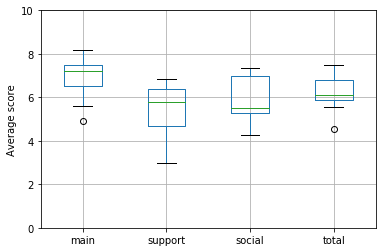

In [12]:
pycon_boxplot = services.boxplot()
plt.ylim([0,10])
pycon_boxplot_ylabel = plt.ylabel(f"Average score")

The box plot shows us that, similarly to the Omni dataset, the `main` scores are slightly higher than those in `support` and `social` aspects. However, this plot ignores the dispersion within the scoring of each service, and only compares across services.

On the other hand, if we calculate the probability mass function (pmf) and the cumulative mass function (cmf) across the entire dataset, the dispersion is better accounted for.

In [13]:
bins = pd.interval_range(start=-0.5, end=10.5)
pycon_freq = pycon.drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
pycon_pmf = pycon_freq/np.sum(pycon_freq)
pycon_cmf = np.cumsum(pycon_pmf)

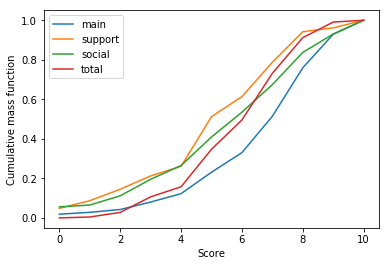

In [14]:
for key in pycon_cmf.keys():
    plt.plot(bins.mid, pycon_cmf[key])

legend = plt.legend()
xlabel = plt.xlabel(f"Score")
ylabel = plt.ylabel(f"Cumulative mass function")

In [15]:
def c(a):
    return np.sqrt(-0.5*np.log(a/2))

def pval(d, n, m):
    return 2*np.exp(-2*d**2*n*m/(n+m))

used = ['total']
for key1 in pycon_cmf.drop(used, axis=1).keys():
    n = np.sum(pycon_freq[key1])
    used.append(key1)
    for key2 in pycon_cmf.drop(used, axis=1).keys():
        m = np.sum(pycon_freq[key2])
        dnm = np.max(np.abs(pycon_cmf[key1]-pycon_cmf[key2]))
        ca = c(0.05)*np.sqrt((n+m)/(n*m))
        pv = pval(dnm, n, m)
        
        print(f"{key1}\t{key2}\t{dnm}\t{ca}\t{pv}\t{dnm>ca}")

main	support	0.2833378908030262	0.13270465039878593	9.949153049792149e-08	True
main	social	0.20469504168494956	0.13144952194644946	0.0002607172479620761	True
support	social	0.11302100887540723	0.1322464603452878	0.13518039729219827	False


These results show that there is a significant difference between the distributions obtained for the `main` scores and the `social` and `support` scores. It is a good indicator that, generally, the expectations of the respondents are different for each attribute. 

One last question remains to be answered regarding our data: are there any correlations between the attributes?

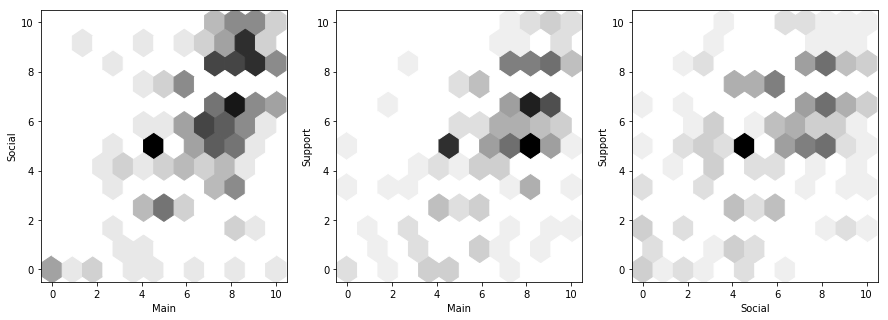

In [26]:
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.hexbin(pycon.main, pycon.social, gridsize=11, cmap='binary');
plt.xlabel(f"Main");
plt.ylabel(f"Social");

plt.subplot(1,3,2)
plt.hexbin(pycon.main, pycon.support, gridsize=11, cmap='binary');
plt.xlabel(f"Main");
plt.ylabel(f"Support");

plt.subplot(1,3,3)
plt.hexbin(pycon.social, pycon.support, gridsize=11, cmap='binary');
plt.xlabel(f"Social");
plt.ylabel(f"Support");

In [17]:
pycon.drop(['name', 'total'], axis=1).corr()

,main,support,social
main,1.000000,0.555287,0.564266
support,0.555287,1.000000,0.469301
social,0.564266,0.469301,1.000000


## Comparative analysis

So far, the analyses conducted on each dataset have given very similar descriptions of the data, which leads us to suspect that there really are no significant differences between the Omni dataset and the PyCon one. This is a sensible hypothesis: after all, the PyCon community is composed mostly of developers, as is the team at Omni Digital. 

However, there are some differences in the rankings of the services. These may be a consequence of certain outliers, as the datasets are very small and any anomaly may bias the data significantly. However, it is more likely that they are simply consequence of the noise in the data. In any case, we need to check whether there are any significant differences between the two datasets. We can use the same Kolmogorov-Smirnov test to perform the analysis.

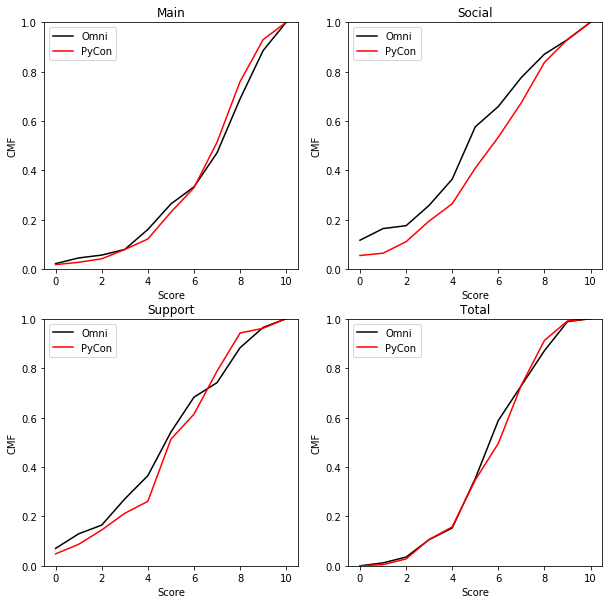

In [18]:
plt.figure(figsize=[10,10])

plt.subplot(2,2,1)
plt.plot(bins.mid, omni_cmf.main, 'k', label='Omni');
plt.plot(bins.mid, pycon_cmf.main, 'r', label='PyCon');
plt.xlabel(f"Score");
plt.ylabel(f"CMF");
plt.title("Main");
plt.ylim([0,1]);
plt.legend();

plt.subplot(2,2,2)
plt.plot(bins.mid, omni_cmf.social, 'k', label='Omni');
plt.plot(bins.mid, pycon_cmf.social, 'r', label='PyCon');
plt.xlabel(f"Score");
plt.ylabel(f"CMF");
plt.title("Social");
plt.ylim([0,1]);
plt.legend();

plt.subplot(2,2,3)
plt.plot(bins.mid, omni_cmf.support, 'k', label='Omni');
plt.plot(bins.mid, pycon_cmf.support, 'r', label='PyCon');
plt.xlabel(f"Score");
plt.ylabel(f"CMF");
plt.title("Support");
plt.ylim([0,1]);
plt.legend();

plt.subplot(2,2,4)
plt.plot(bins.mid, omni_cmf.total, 'k', label='Omni');
plt.plot(bins.mid, pycon_cmf.total, 'r', label='PyCon');
plt.xlabel(f"Score");
plt.ylabel(f"CMF");
plt.title("Total");
plt.ylim([0,1]);
plt.legend();

Visual exploration reveals that the plots generally seem to look the same. We can now perform the two-sample KS test for each attribute.

In [19]:
def c(a):
    return np.sqrt(-0.5*np.log(a/2))

def pval(d, n, m):
    return 2*np.exp(-2*d**2*n*m/(n+m))

for key in omni_cmf.keys():
    dnm = np.max(np.abs(omni_cmf[key]-pycon_cmf[key]))
    m = np.sum(omni_freq[key])
    n = np.sum(pycon_freq[key])
    ca = c(0.05)*np.sqrt((n+m)/(n*m))
    pv = pval(dnm, n, m)
        
    print(f"{key}\t{dnm}\t{ca}\t{pv}\t{dnm>ca}")

main	0.0697787898503579	0.1729180268931405	1.0968504172107258	False
support	0.10383631713554986	0.17495607377921582	0.5454036049057487	False
social	0.16716826265389872	0.17400597787065972	0.06643620585808432	False
total	0.09286492374727673	0.17389181613003385	0.6984367933814267	False


## Analysis of services

Having confirmed that there are no significant differences between the Omni subset and the PyCon subset, we can analyse each service separately. These analysis are less reliable due to the reduced size of their respective datasets, because each survey instance is composed of 11 services and they accumulate when averaging them out.

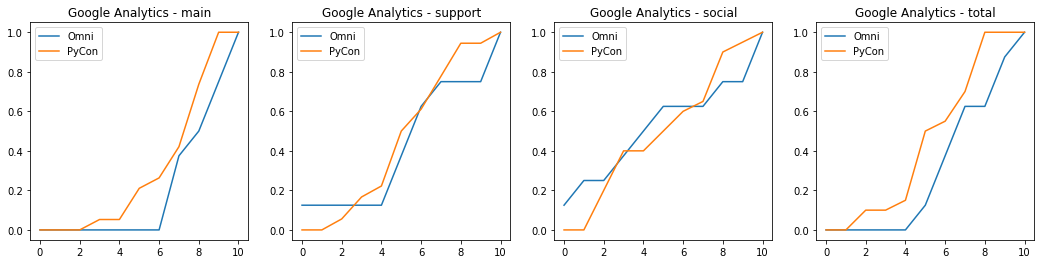

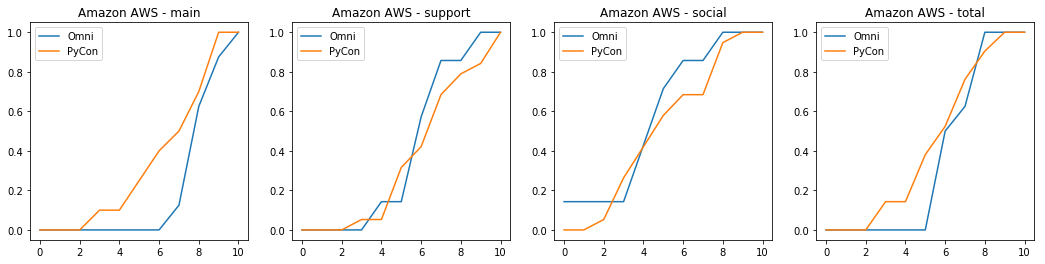

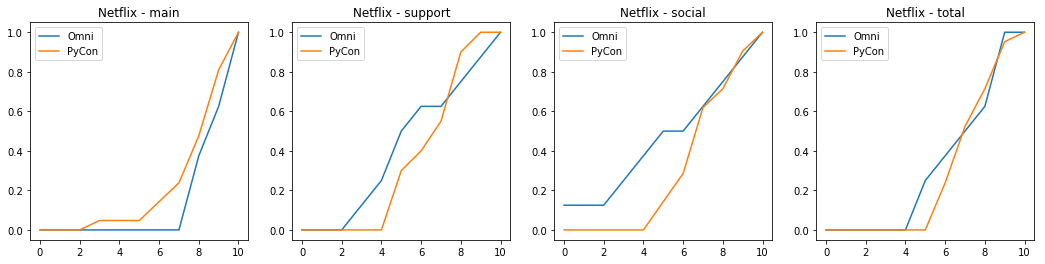

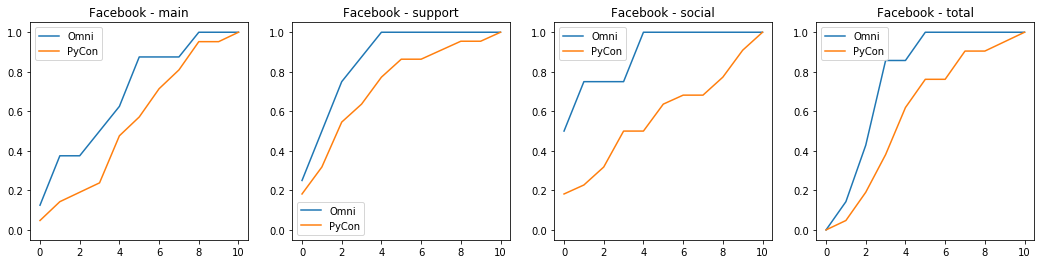

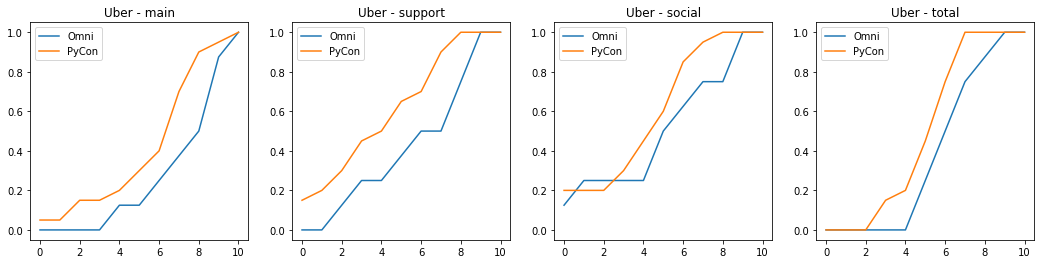

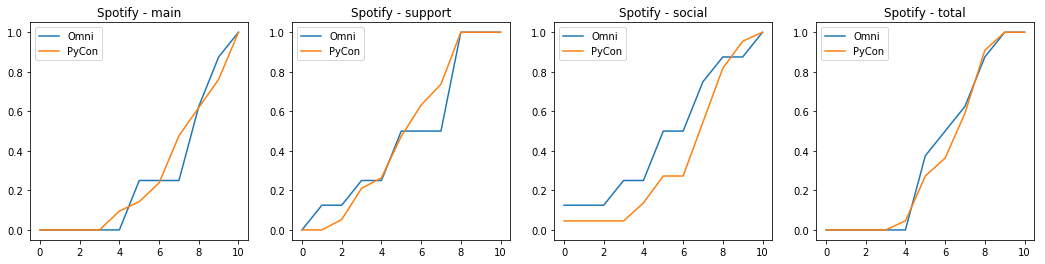

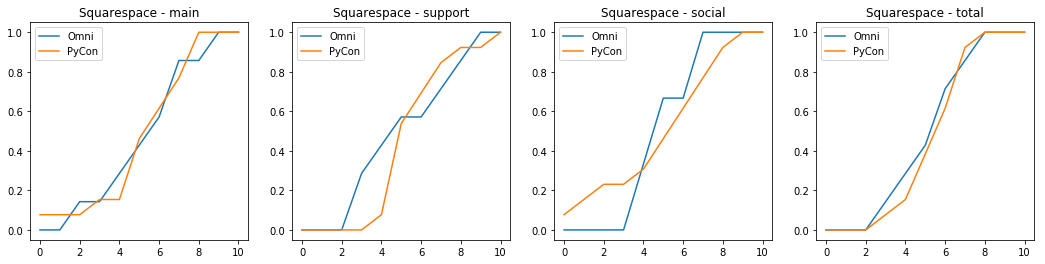

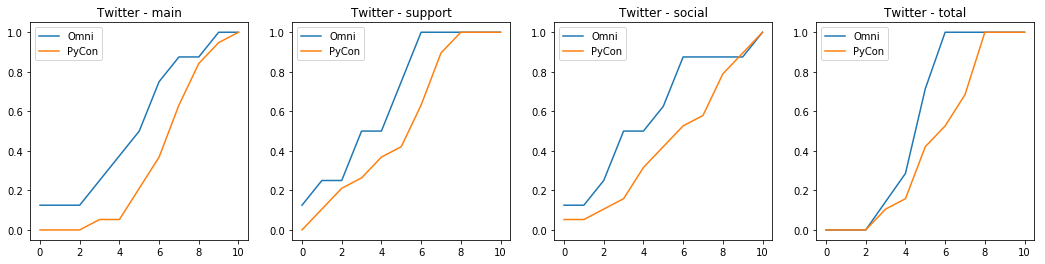

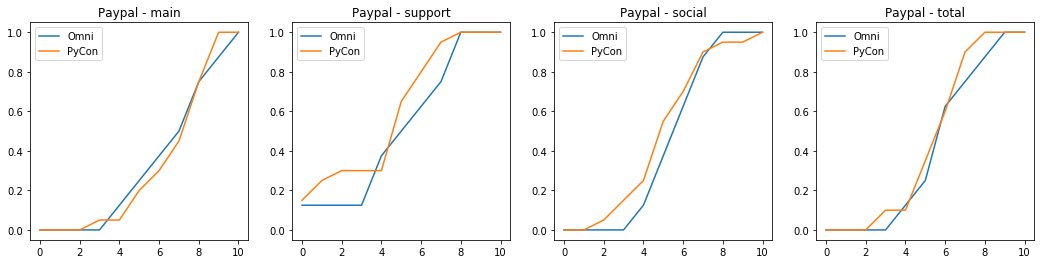

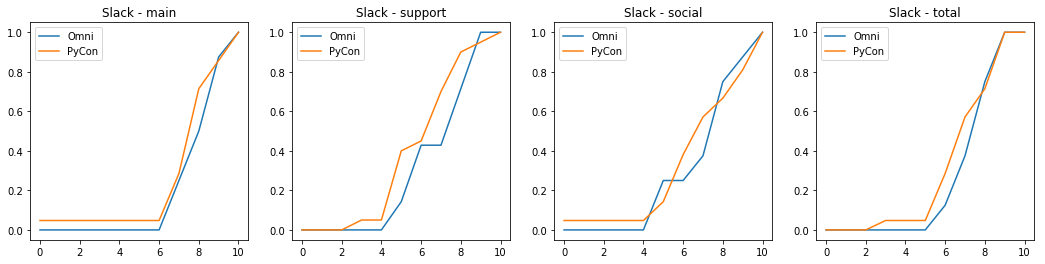

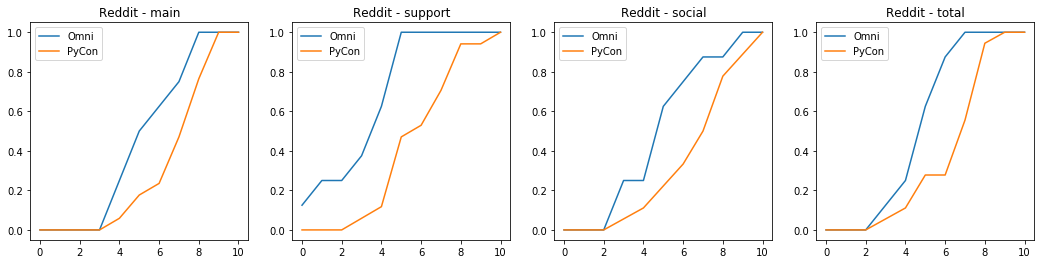

In [20]:
for service in df.name.unique():
    fig, axes = plt.subplots(nrows=1, ncols=4, squeeze=True, figsize=[18,4])

    omni_freq = omni.loc[omni.name == service].drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
    omni_pmf = omni_freq / np.sum(omni_freq)
    omni_cmf = np.cumsum(omni_pmf)
    
    pycon_freq = pycon.loc[pycon.name == service].drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
    pycon_pmf = pycon_freq / np.sum(pycon_freq)
    pycon_cmf = np.cumsum(pycon_pmf)
    
    for i, key in enumerate(omni_freq.keys()):
        ax = axes[i]
        ax.plot(bins.mid, omni_cmf[key], label="Omni")
        ax.plot(bins.mid, pycon_cmf[key], label="PyCon")
        ax.set_title(f"{service} - {key}")
        ax.set_ylim([-0.05, 1.05])
        ax.legend()

The Kolmogorov-Smirnov calculation would very nearly be rendered useless for such low counts of instances. For the sake of completion, we can quickly calculate it. For the maximum counts available in each subset, the threshold for a 95% confidence interval would be:

$$ c(\alpha) \sqrt{\frac{n+m}{nm}} = c(0.05) \sqrt{\frac{30}{176}} \simeq 0.54 $$

Any null responses will imply a lower count, which translates to an even higher threshold. Thus, we can safely assume that any pair of distributions with a supremum of the difference of more than 0.54 will be flagged as having significant differences.

In [21]:
for service in df.name.unique():
    omni_freq = omni.loc[omni.name == service].drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
    omni_pmf = omni_freq / np.sum(omni_freq)
    omni_cmf = np.cumsum(omni_pmf)
    
    pycon_freq = pycon.loc[pycon.name == service].drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
    pycon_pmf = pycon_freq / np.sum(pycon_freq)
    pycon_cmf = np.cumsum(pycon_pmf)
    
    for key in omni_cmf.keys():
        dnm = np.max(np.abs(omni_cmf[key] - pycon_cmf[key]))
        if dnm > 0.54:
            print(f"{service} [{key}]: {dnm:.4f} - {dnm > 0.54}")

Reddit [total]: 0.5972 - True


Interestingly, the only service that significantly differs is _Reddit_, and only in the distribution of its average scores, but not in the distribution of its component scores. This is a symptom of the larger issue with this analysis: the sample size is very reduced and severely limits our ability to make guesses about the actual dispersion of the scores in the population. Nontheless, it is safe to say that the apparent differences in the rankings do not actually represent significant differences in the underlying biases and opinions of the two collectives.